# <font color=#B2D732> <span style="background-color: #4424D6"> Brain & Spinal Cord fMRI preprocessings </font>
<hr style="border:1px solid black">  

*Project: 2024_brsc_fc_project*  
*Paper: Landelle, Kinany et al. 204*  
**@ author:** 
> Caroline Landelle, caroline.landelle@mcgill.ca // landelle.caroline@gmail.com  
> Nawal Kinany, nawal.kinany@epfl.ch  
> July 2020 (last update: 11 March 2024)

**Description:** 
> This notebook provides code for preprocessing fMRI data of simultaneous brain and spinal cord acquisition (single FOV).   


**Associated files:**
> - ../config/01_brsc_preprocess.json ; This file contains the directories and should be modified first
> - ../brsc_preprocess.py ; Nothing should be changed in this file
> - ../BrSc_utils.py; Nothing should be changed in this file

**Steps:**
> **I. Brain and spinal cord preprocessings**  
> I.1 Slice timing correction  
> I.2 Crop anat and func images brain and spinal cord  

> **II. Brain preprocessings**  
> II.1 Motion correction  
> II.2 Segmentation   
> II.3 Brain coregistration into T1w

> **III. Spinal cord preprocessings**  
> III.1 Motion correction  
> III.2 Segmentation   
> III.3 Labeling of the inter vertebral disk  
> III.4 Coregistration to PAM50 template  

<hr style="border:1px solid black">

to do:
- check run nomemclature

## <font color=#B2D732> <span style="background-color: #4424D6">  Imports & configuration </font >

In [64]:
import sys, json, glob, os
code_dir="/cerebro/cerebro1/dataset/bmpd/derivatives/HealthyControls_project/2024_brsc_fc_project/"
os.chdir(code_dir)
sys.path.append(code_dir + "/code/") # Change this line according to your directory

from brsc_preprocess import Preprocess_BrSc, Preprocess_Sc, Preprocess_Br
import BrSc_utils as utils
#
%load_ext autoreload
%autoreload 2
%matplotlib inline
    
# Load config file ------------------------------------------------------------
# The config file should be first review and all path should be modified (lines: )
with open(code_dir + '/config/01_brsc_preprocess.json') as config_file: # the notebook should be in 'xx/notebook/' folder #config_proprio
    config = json.load(config_file) # load config file should be open first and the path inside modified
    
preprocess_BrSc=Preprocess_BrSc(config) # initialize the function
preprocess_Sc=Preprocess_Sc(config) # initialize the function
preprocess_Br=Preprocess_Br(config) # initialize the function


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Lines 0-10 of config files should be manually modified first
All the raw data should be store in BIDS format
 
sub-P099 have a anat filename specitity: run-02


<hr style="border:1px solid black">    

## <font color=#B2D732> <span style="background-color: #4424D6"> I Brain and spinal cord preprocessings </font>
### I.1 Slice timing correction   
Slice timing correction is applied in order to minimize the effect of slice ordering in the acquisition of the images.   
if you acquired the same file twice add info about the file to select ex: tag="run-02"



In [65]:
stc_files=[] # will contain the output filename for all participants.

for ID in config["participants_IDs"]:
    func_tag = config['files_specificities']["func"].get(ID, "") # if you provided filename specifity it will be take into account   
    stc_files.append(preprocess_BrSc.stc(ID=ID,task_name='',t_custom=True, redo=False,tag=func_tag)) 

/cerebro/cerebro1/dataset//bmpd/derivatives/HealthyControls_project/2024_brsc_fc_data/rawdata/sub-P030//func/sub-P030****.nii*
input image is: /cerebro/cerebro1/dataset//bmpd/derivatives/HealthyControls_project/2024_brsc_fc_data/rawdata/sub-P030//func/sub-P030_task-rest_bold.nii.gz
/cerebro/cerebro1/dataset//bmpd/derivatives/HealthyControls_project/2024_brsc_fc_data/rawdata/sub-P099//func/sub-P099***run-02*.nii*
input image is: /cerebro/cerebro1/dataset//bmpd/derivatives/HealthyControls_project/2024_brsc_fc_data/rawdata/sub-P099//func/sub-P099_task-rest_run-02_bold.nii.gz


### I.2 Crop anat and func images brain and spinal cord
We separate brain and spinal cord because the next steps use differents apparoaches in each regionfolder.   
For now we are using a manual selection of the slices to crop (saved in a .tsv file)

In [71]:
tsv_f=config["main_dir"]+config["preprocess_dir"]["main_dir"]+ "brsc_participants.tsv" # the tsv files with info about each participants
func_stc_cropped=[];anat_files=[];func_stc_brain_tmean=[];func_stc_sc_tmean=[];anat_stc_cropped=[]
tag_anat=""

for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    # crop func image:
    func_stc_cropped.append(preprocess_BrSc.crop_img(ID=ID,i_img=stc_files[ID_nb],tsv_f=tsv_f,img_type="func",redo=False,verbose=True)) # crop the func images
    func_stc_brain_tmean.append(utils.tmean_img(ID=ID,i_img=func_stc_cropped[ID_nb][0],verbose=True)) # calculate the brain mean image
    func_stc_sc_tmean.append(utils.tmean_img(ID=ID,i_img=func_stc_cropped[ID_nb][1],verbose=True)) # calculate the spinalcord mean image
    
    # crop anat image:
    if ID in config['files_specificities']["anat"]:
        tag_anat=config['files_specificities']["anat"][ID] # if you provided filename specifity it will be take into account 
    anat_files.append(glob.glob(config["main_dir"]+config["raw_dir"] + "/sub-" + ID+ "/anat/*"+tag_anat+"*T1w*.nii.gz")[0])
    o_folder=config["main_dir"]+config["preprocess_dir"]["main_dir"]+  "/sub-" + ID+ "/anat/"
    anat_stc_cropped.append(preprocess_BrSc.crop_img(ID=ID,i_img=anat_files[ID_nb],o_folder=o_folder,tsv_f=tsv_f,img_type="anat",redo=False))
    

Done : check the outputs files in fsleyes by copy and past:
fsleyes /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing//sub-P030//func///1_STC/brain/sub-P030_task-rest_bold_stc_brain_tmean.nii.gz
Done : check the outputs files in fsleyes by copy and past:
fsleyes /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing//sub-P030//func///1_STC/spinalcord/sub-P030_task-rest_bold_stc_sc_tmean.nii.gz
Done : check the outputs files in fsleyes by copy and past:
fsleyes /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing//sub-P099//func///1_STC/brain/sub-P099_task-rest_run-02_bold_stc_brain_tmean.nii.gz
Done : check the outputs files in fsleyes by copy and past:
fsleyes /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing//sub-P099//func///1_STC/spinalcord/sub-P099_task-rest_run-02_bold_stc_sc_tmean.nii.gz


<hr style="border:1px solid black">    

## <font color=#B2D732> <span style="background-color: #4424D6">  II. Brain preprocessings </font>

### II.1 Motion correction

0
Compute framewise displacement for sub-P030
Mean FD for sub-P030: 0.122 mm


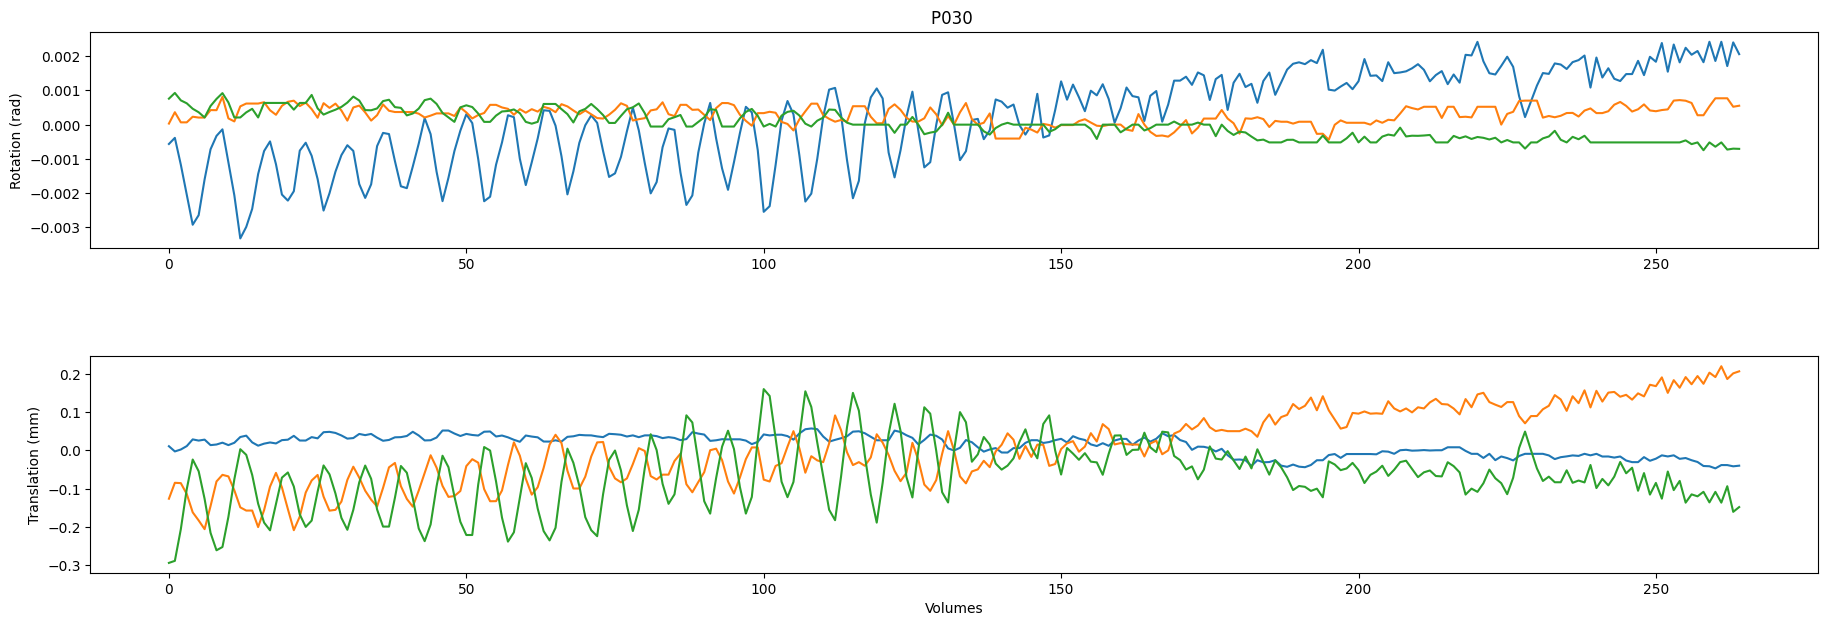

 
1
Compute framewise displacement for sub-P099
Mean FD for sub-P099: 0.049 mm


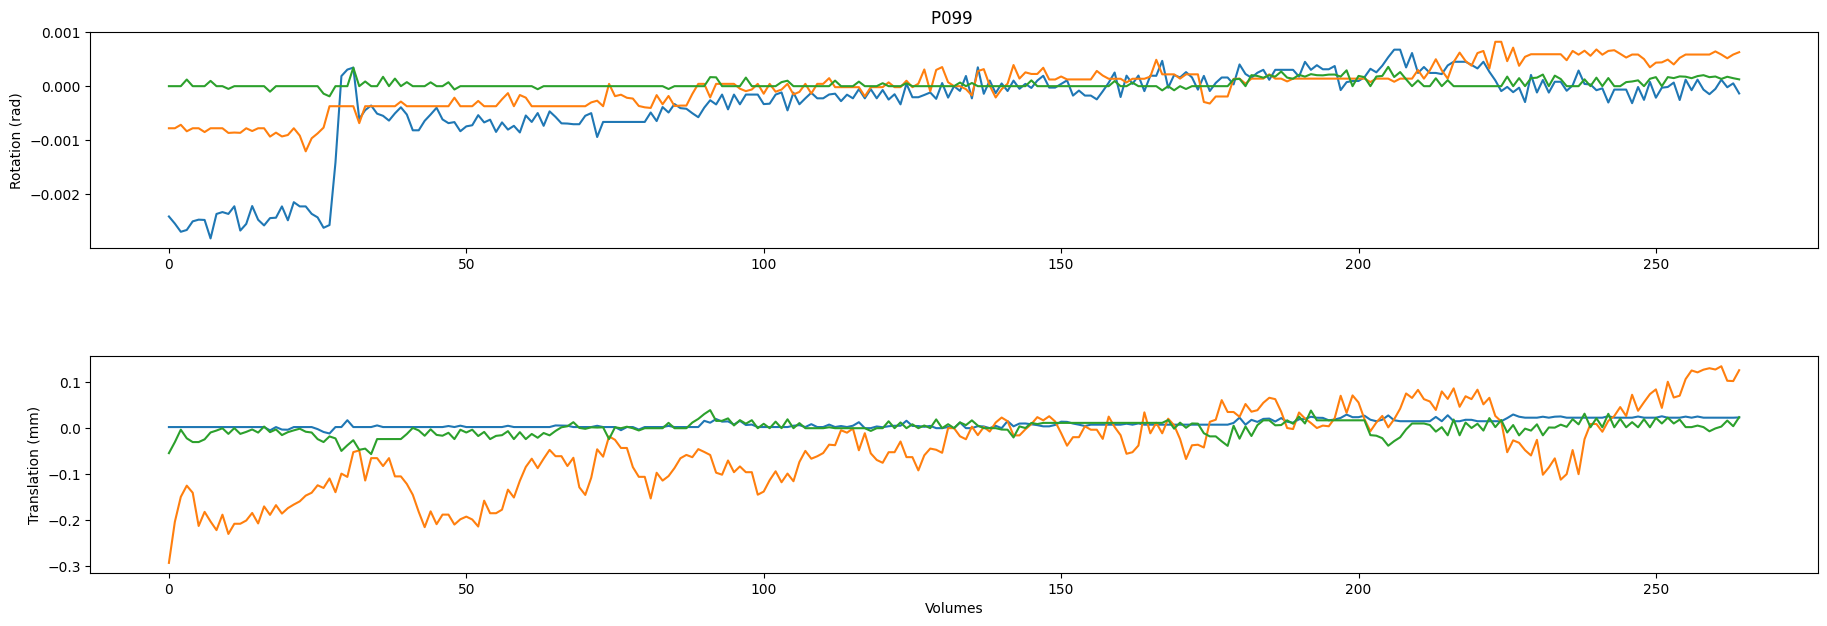

In [72]:
moco_brain_files=[] # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    print(ID_nb)
    ID=config["participants_IDs"][ID_nb]
    moco_brain_files.append(preprocess_Br.moco(ID=ID,i_img=func_stc_cropped[ID_nb][0],plot_show=True,redo=False))


### II.2 Segmentation and Normalization
This step provide tissue segmentation and warpping field to MNI space
*This step requires matlab.engine it should be install correctly*

In [73]:
seg_brain_folder=[] # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    seg_brain_folder.append(preprocess_Br.segmentation(ID=ID,i_img=anat_stc_cropped[ID_nb][0],redo=False))


Brain segmentation alredy exists for sub-P030 here: /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P030/anat//brain/segmentation/
Brain segmentation alredy exists for sub-P099 here: /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P099/anat//brain/segmentation/


### II.3 Brain coregistration into T1w
This step is useful to generate a csf mask for the denoising step

In [74]:
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    preprocess_Br.coreg_anat2func(ID=ID,
                                  func_img=moco_brain_files[ID_nb][1],
                                  anat_img=glob.glob(seg_brain_folder[ID_nb].split('mri')[0] + "*masked.nii.gz")[0],
                                  other_img=glob.glob(seg_brain_folder[ID_nb] + "p3*_brain.nii")[0],
                                  wm_file=glob.glob(seg_brain_folder[ID_nb] + "p2*_brain.nii")[0],
                                  tag="_reg",
                                  redo=False,verbose=True)

/cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P030//func///5_Coregistration//brain/sub-P030_task-rest_bold_stc_brain_moco_mean_reg.mat
/cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P099//func///5_Coregistration//brain/sub-P099_task-rest_run-02_bold_stc_brain_moco_mean_reg.mat


<hr style="border:1px solid black">

## <font color=#B2D732> <span style="background-color: #4424D6"> III. Spinal cord preprocessings </font>
### III.1 Motion correction 
#### a. Create the centerline and surrounding mask 
> - the centerline of the spinal cord was automatically extracted from the mean image or can be draw manually when it is necessary (manual=True), for manual step you should <span style="background-color: #FFFACD"> start at the very first slice </span> , otherwise the mask and the mean func image size will differ
> - A cylindrical mask with a diameter of 15 mm is drawn along this centerline and further used to exclude regions outside the spinal cord from the motion correction procedure, as those regions may move independently from the cord.   

<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  Manual step is required  </span> 

In [75]:
mocomask_sc_files=[] # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    mocomask_sc_files.append(preprocess_Sc.moco_mask(ID=ID,i_img=func_stc_sc_tmean[ID_nb],manual=False,redo=False))


--
Spinal Cord Toolbox (5.6)

sct_get_centerline -i /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing//sub-P030//func///1_STC/spinalcord/sub-P030_task-rest_bold_stc_sc_tmean.nii.gz -o /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P030//func///2_Coarse_mask//spinalcord/sub-P030_task-rest_bold_stc_sc_tmean_centerline -c t1 -method optic -centerline-algo bspline
--

Creating temporary folder (/tmp/sct-20240328115202.617264-zf0esofm)
Remove temporary files...
rm -rf /tmp/sct-20240328115202.617264-zf0esofm
File /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P030//func///2_Coarse_mask//spinalcord/sub-P030_task-rest_bold_stc_sc_tmean_centerline.nii.gz already exists. Will overwrite it.

Done! To view results, run one of the following commands (depending on your preferred viewer):
fsleyes /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing//sub-P030//func///1_STC/spinalcord/sub-P030_task-rest_bold_stc_sc_tmean.nii.gz

/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/spinalcordtoolbox-5.6.0/spinalcordtoolbox/scripts/sct_create_mask.py:229: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  hdr = centerline.get_header()  # get header
/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/spinalcordtoolbox-5.6.0/spinalcordtoolbox/scripts/sct_create_mask.py:232: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data_centerline = centerline.get_data()  # get centerline


Mask created, check the outputs files in fsleyes by copy and paste:
fsleyes /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P030//func///2_Coarse_mask//spinalcord/sub-P030_task-rest_bold_stc_sc_tmean_mask.nii.gz
use manual=False if the centerline need manual corrections

--
Spinal Cord Toolbox (5.6)

sct_get_centerline -i /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing//sub-P099//func///1_STC/spinalcord/sub-P099_task-rest_run-02_bold_stc_sc_tmean.nii.gz -o /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P099//func///2_Coarse_mask//spinalcord/sub-P099_task-rest_run-02_bold_stc_sc_tmean_centerline -c t1 -method optic -centerline-algo bspline
--

Creating temporary folder (/tmp/sct-20240328115217.591057-gmotkp0o)
Remove temporary files...
rm -rf /tmp/sct-20240328115217.591057-gmotkp0o
File /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P099//func///2_Coarse_mask//spinalcord/sub-P099_task-rest_run-02_bold_

/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/spinalcordtoolbox-5.6.0/spinalcordtoolbox/scripts/sct_create_mask.py:229: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  hdr = centerline.get_header()  # get header
/cerebro/cerebro1/dataset/bmpd/derivatives/thibault_test/code/toolbox/spinalcordtoolbox-5.6.0/spinalcordtoolbox/scripts/sct_create_mask.py:232: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data_centerline = centerline.get_data()  # get centerline


Mask created, check the outputs files in fsleyes by copy and paste:
fsleyes /cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P099//func///2_Coarse_mask//spinalcord/sub-P099_task-rest_run-02_bold_stc_sc_tmean_mask.nii.gz
use manual=False if the centerline need manual corrections


#### b. Calculate moco </font > 

/cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P030//func///3_MOCO//spinalcord/sub-P030_task-rest_bold_stc_sc_moco.nii.gz


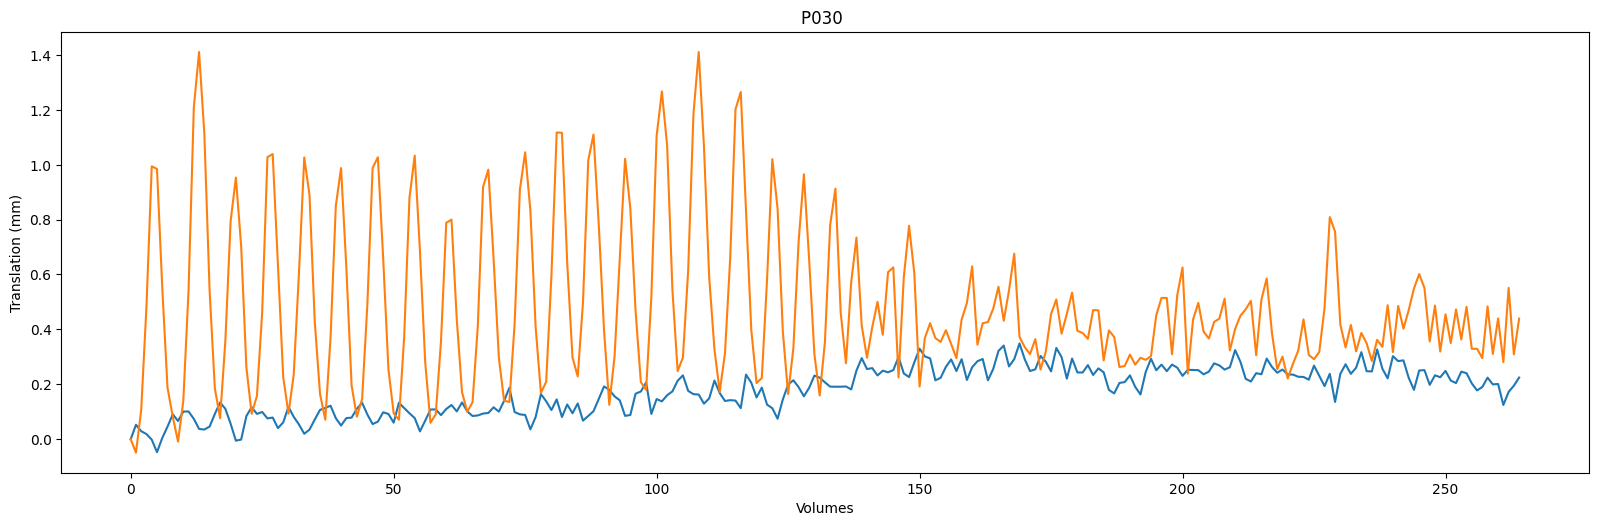

Framewise displacement, sub-P030
Diff_X: 0.033 mm
Diff_Y: 0.199 mm
/cerebro/cerebro1/dataset/bmpd//derivatives/spinalcord_processing/sub-P099//func///3_MOCO//spinalcord/sub-P099_task-rest_run-02_bold_stc_sc_moco.nii.gz


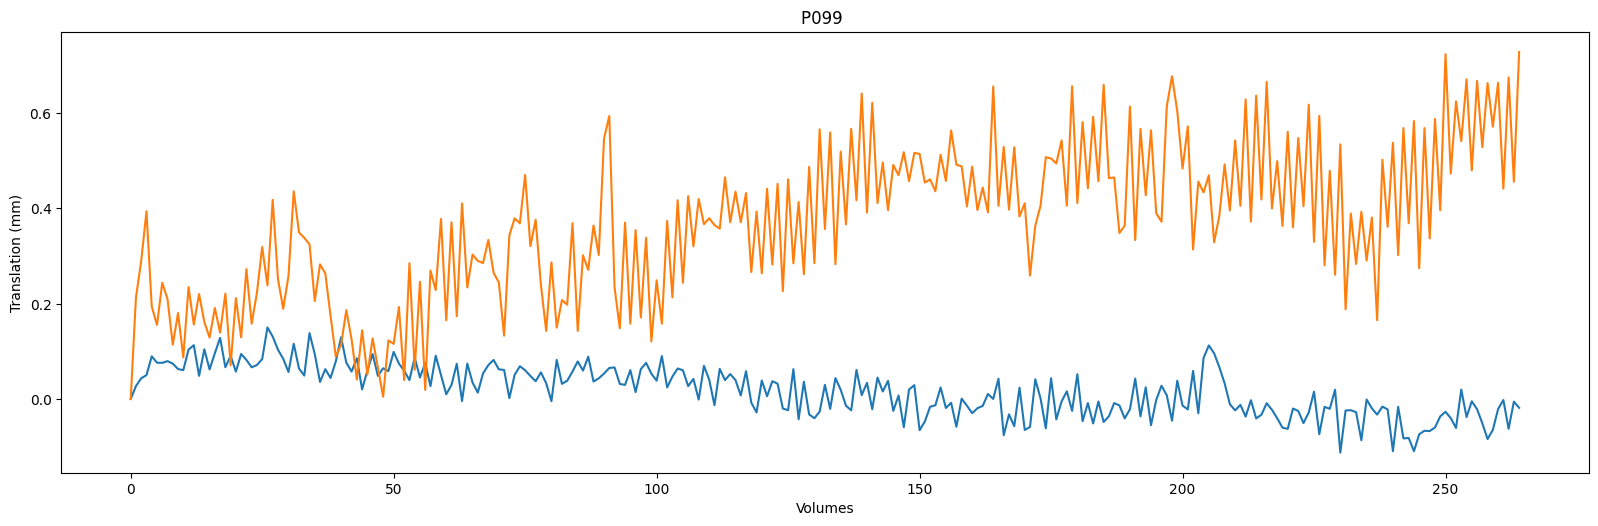

Framewise displacement, sub-P099
Diff_X: 0.037 mm
Diff_Y: 0.137 mm


In [76]:

moco_sc_files=[] # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    # clean you remporary folder between each individuals if necessary:
    string='find /tmp /var/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;' ; os.system(string)
    string='find /tmp /var/tmp /export02/data/tmp -maxdepth 1 -user landelle -exec rm -rf {} \;'; os.system(string)

    moco_sc_files.append(preprocess_Sc.moco(ID=ID,i_img=func_stc_cropped[ID_nb][1],mask_img=mocomask_sc_files[ID_nb][0],plot_show=True,redo=False))


### III.2 Segmentation
#### a segment the spinal cord (WM+GM)
<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  In this dataset the segmentation mask were all corrected manually by overighting the file: **/func///4_Segmentation//spinalcord/*seg.nii.gz  </span> 

In [13]:
seg_anat_sc_files=[];seg_func_sc_files=[] # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    seg_anat_sc_files.append(preprocess_Sc.segmentation(ID=ID,i_img=anat_stc_cropped[ID_nb][1],img_type="anat",redo=False,verbose=True))
    seg_func_sc_files.append(preprocess_Sc.segmentation(ID=ID,i_img=moco_sc_files[ID_nb][1],
                                                        ctr_img=mocomask_sc_files[ID_nb][1] ,img_type="func",redo=False,verbose=True))


>>>>> Segmentation file already exists for the anatimage of the sub-A006_test 
fsleyes /cerebro/cerebro1/dataset/stratals//derivatives/preprocessing/sub-A006_test//anat//T1w_seg/sub-A006_test_T1w_sc_seg.nii.gz
 
>>>>> Segmentation file already exists for the funcimage of the sub-A006_test 
fsleyes /cerebro/cerebro1/dataset/stratals//derivatives/preprocessing/sub-A006_test//func///4_Segmentation//cord/spinalcord/sub-A006_test_task-rest_bold_stc_sc_moco_mean_seg.nii.gz
 


### III.3 Labeling of the inter vertebral disk
> This manual step should open a windows.  
> Place labels at the posterior tip of each inter-vertebral disc starting from 1  

exemple here (right, in green): https://spinalcordtoolbox.com/user_section/tutorials/vertebral-labeling/labeling-conventions.html

In [14]:
vert_labels_files=[]; # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    vert_labels_files.append(preprocess_Sc.label_vertebrae(ID=ID,i_img=anat_stc_cropped[ID_nb][1],redo=True,verbose=True))

Place labels at the posterior tip of each inter-vertebral disc for sub-A006_test

--
Spinal Cord Toolbox (5.6)

sct_label_utils -i /cerebro/cerebro1/dataset/stratals//derivatives/preprocessing//sub-A006_test/anat/sub-A006_test_T1w_sc.nii.gz -o /cerebro/cerebro1/dataset/stratals//derivatives/preprocessing/sub-A006_test//anat//T1w_seg/sub-A006_test_T1w_sc_label-ivd_mask.nii.gz -create-viewer 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
--



qt.qpa.plugin: Could not load the Qt platform plugin "xcb" in "" even though it was found.
This application failed to start because no Qt platform plugin could be initialized. Reinstalling the application may fix this problem.

Available platform plugins are: eglfs, linuxfb, minimal, minimalegl, offscreen, vnc, wayland-egl, wayland, wayland-xcomposite-egl, wayland-xcomposite-glx, webgl, xcb.



### III.4 Coregistration to PAM50 template
#### a Coregistration between anat image and PAM50
see details here: https://spinalcordtoolbox.com/user_section/tutorials/registration-to-template/template-registration.html

In [17]:
warpT1w_PAM50_files=[]; # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    warpT1w_PAM50_files.append(preprocess_Sc.coreg_anat2PAM50(ID=ID,i_img=anat_stc_cropped[ID_nb][1],seg_img=seg_anat_sc_files[ID_nb],
                                                          labels_img=vert_labels_files[ID_nb],
                                                          img_type="t1",tag='T1w',
                                                          redo=False,verbose=True))

>>>>> Registration file anat2template already exists for sub-A006_test
 


#### b Coregistration between func image and PAM50

In [21]:
%%capture
func2PAM50_dir=[]; # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    func2PAM50_dir.append(preprocess_Sc.coreg_func2PAM50(ID=ID,i_img=moco_sc_files[ID_nb][1],func_seg=seg_func_sc_files[ID_nb],
                                                          initwarp=warpT1w_PAM50_files[ID_nb][0],initwarpinv=warpT1w_PAM50_files[ID_nb][1],
                                                          redo=False,verbose=True))

#### c Coregistration csf segmentation in func space
This step is necessary to apply denoising in native space.   
<span style="background-color: #FFFACD"> <font color=#efb017> **/!\**  </font>  Check the spinal cord csf output and correct it manually,  </span> 


In [24]:
sc_CSFinFunc_files=[];  # will contain the output filename for all participants.
for ID_nb in range(0,len(config["participants_IDs"])):
    ID=config["participants_IDs"][ID_nb]
    # >>>>>>> Spinal cord <<<<<<<<<
    # Select files
    sc_csf_file=config["tools_dir"]["main_codes"] + '/template/' + config["PAM50_csf"]
    sc_warp_file=glob.glob(func2PAM50_dir[ID_nb] +'*from-PAM50_to_func*')[0]
    # Run transformation
    sc_CSFinFunc_files.append(preprocess_Sc.apply_warp(ID=ID,i_img=sc_csf_file,
                                                       dest_img=moco_sc_files[ID_nb][1],
                                                       warping_field=sc_warp_file,tag='_inFunc',
                                                       threshold=0.3,redo=False,verbose=True))
    

 
>>>>> Apply transformation to sub-A006_test
Tranformation was already applied put redo=True to redo that step
